Ideas:
- Jenzen et. al
- [Background Subtraction](https://docs.opencv.org/3.3.0/d1/dc5/tutorial_background_subtraction.html) on the images. If you have the Background image without the animal, you can simply subtract it from the current image to get just the animal. Once you have just the animal, you can apply SIFT or CNNs or whatever. This is called frame differencing. https://datascience.stackexchange.com/questions/22981/data-preprocessing-how-separate-background-from-image-to-detect-animals


# Setup

In [2]:
import pandas as pd
import json
import os
import re
import shutil #save images
from tqdm import tqdm #progress bar

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth  #Authenticate
auth.authenticate_user()

Mounted at /content/drive


In [3]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   4985      0 --:--:-- --:--:-- --:--:--  5009
OK
49 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 11.0 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unsele

In [4]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"
json_path = f"{local_path}/raw-data/orinoquia-camera-traps/orinoquia_camera_traps.json"
base_path = f"{local_path}/raw-data/orinoquia-camera-traps/public"
output_path = f"{local_path}/raw-data/downsampled-data"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721866288,"nanos":558070676},"severity":"INFO","message":"Start gcsfuse/2.3.2 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721866288,"nanos":558406991},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [5]:
image_labels = pd.read_csv('/content/drive/MyDrive/w281_Project/0_data/sample_images/images_labels.csv')

#split filename into camera and image number
image_labels['camera'] = image_labels['filename'].str.split('/').str[0]
image_labels['image_number'] = image_labels['filename'].str.split('/').str[1]

image_labels.head()

,filename,timestamp,image_id,common_name,sp_num,camera,image_number
0,N25/03310082.JPG,2020-03-31T14:28:14Z,902b671f-58b9-4cb0-9898-bd53c9909e51,Collared Peccary,1,N25,03310082.JPG
1,N29/03310288.JPG,2020-03-31T06:49:17Z,e727dc42-5ebb-46a0-a979-eac158c050e6,Collared Peccary,1,N29,03310288.JPG
2,A06/06020479.JPG,2020-06-02T08:12:17Z,db3c3213-5ad9-4bf7-94a8-92ded5efb5a5,Black Agouti,1,A06,06020479.JPG
3,A02/03100387.JPG,2020-03-10T06:58:27Z,c7e33138-08ac-461d-a267-ba44a2f123ad,Unknown species,1,A02,03100387.JPG
4,A04/04180034.JPG,2020-04-18T05:37:56Z,52f77e0c-7023-4087-8414-26848579d14f,Bos Species,1,A04,04180034.JPG


# Identify cameras with blank images

In [6]:
species_list = ['Collared Peccary','White-lipped Peccary','Black Agouti',
                'Spotted Paca','Dasypus Species','South American Coati',
                'Domestic Horse','Bos Species','Blank']

our_species = image_labels[image_labels['common_name'].isin(species_list)]

camera_list = list(our_species['camera'].unique())
print(camera_list)

['N25', 'N29', 'A06', 'A04', 'A07', 'A09', 'M04', 'N08', 'N10', 'N30', 'N14', 'N33', 'A08', 'M05', 'N00', 'N04', 'N07', 'N17', 'N20', 'N26', 'M01', 'N11', 'N27', 'N19', 'N22', 'N21', 'A05', 'N12', 'N36', 'N34', 'A03', 'M02', 'N13', 'M00', 'N06', 'N09', 'N03', 'M03', 'N15', 'N02', 'N05', 'A01', 'A02', 'N31', 'N01', 'N16', 'N24']


In [7]:
# subset of animals from cameras which have a blank image
blank_animals = our_species[our_species['common_name'] == 'Blank']
list(blank_animals['camera'].unique())

['M04',
 'N10',
 'N30',
 'N29',
 'A04',
 'N14',
 'N33',
 'M05',
 'N11',
 'N19',
 'N27',
 'N04',
 'N22',
 'N00',
 'N07',
 'N36',
 'N21',
 'M02',
 'A05',
 'A09',
 'N06',
 'N13',
 'A06',
 'M01',
 'N34',
 'N15',
 'M00',
 'N25',
 'A01',
 'N12',
 'N17',
 'N31',
 'M03',
 'N20',
 'N02',
 'A08',
 'N01',
 'A07',
 'A02',
 'N08',
 'N09',
 'N05',
 'N26',
 'A03',
 'N16',
 'N24',
 'N03']

In [8]:
# select images from our_species from cameras in list(blank_animals['camera'].unique())
blank_images = our_species[our_species['camera'].isin(list(blank_animals['camera'].unique()))]
len(blank_images)

80667

In [9]:
!ls -lh {local_path}/raw-data/orinoquia-camera-traps/


total 73G
-rw-r--r-- 1 root root  72G Jun 18 14:49 orinoquia_camera_traps_images.zip
-rw-r--r-- 1 root root  46M Jan  9  2022 orinoquia_camera_traps.json
-rw-r--r-- 1 root root 2.4M Jun 18 14:49 orinoquia_camera_traps_metadata.zip
drwxr-xr-x 1 root root    0 Jul 25 00:11 public


In [30]:
# find file name for image_labels

sample_species_list = ['Collared Peccary',
                'Blank']

sample_species_df = image_labels[image_labels['common_name'].isin(sample_species_list)].sort_values('camera')
sample_species_df.head(15)


,filename,timestamp,image_id,common_name,sp_num,camera,image_number
23255,A01/03170514.JPG,2020-03-17T05:48:38Z,1f51ae45-b66f-456c-992c-53ab0e366075,Blank,1,A01,03170514.JPG
35590,A01/03020311.JPG,2020-03-02T21:12:11Z,dfafc7ad-46f1-4dce-a124-cad90e6bd473,Collared Peccary,1,A01,03020311.JPG
62824,A01/03070453.JPG,2020-03-07T20:40:22Z,80914a7c-95fa-4603-8c5d-4093199688f8,Collared Peccary,1,A01,03070453.JPG
62315,A01/02250265.JPG,2020-02-25T17:32:38Z,cc250b02-4407-464e-89e8-4fea403caa06,Collared Peccary,1,A01,02250265.JPG
14236,A01/03200578.JPG,2020-03-20T12:50:20Z,1d6b0430-7842-4710-bb80-85df0ee76b1d,Blank,1,A01,03200578.JPG
93168,A01/03250613.JPG,2020-03-25T18:22:51Z,7a0ea1e8-f70f-4a2c-a3d1-cac81c4ee0e0,Blank,1,A01,03250613.JPG
54102,A01/04140686.JPG,2020-04-14T22:24:28Z,b6c6ccac-3a3b-4a86-b659-deecd5cc4998,Blank,1,A01,04140686.JPG
889,A01/02250267.JPG,2020-02-25T17:32:40Z,24b2d595-7fc3-4a74-8a93-a11ed2b296e1,Collared Peccary,1,A01,02250267.JPG
45603,A01/05200755.JPG,2020-05-20T20:55:36Z,b4fdab77-3c08-40e1-b898-2360b288fd64,Blank,1,A01,05200755.JPG
43613,A01/03190557.JPG,2020-03-19T06:02:36Z,d73bfcde-455f-4e30-b50c-1055e7fc65e7,Blank,1,A01,03190557.JPG


# Select sample images from cameras with blank images

In [31]:
blank =  f"{base_path}/A01/03170514.JPG"
# now create a list of blanks for the A01 camera for testing (copying from above output the first 5 blanks)
blanks = [blank, f"{base_path}/A01/03200578.JPG", f"{base_path}/A01/03250613.JPG", f"{base_path}/A01/04140686.JPG", f"{base_path}/A01/05200755.JPG"]
cpec = f"{base_path}/A01/03020311.JPG"


sample_filenames = ['blank','cpec']

In [12]:
blank_im = cv2.imread(blank)
cpec_im = cv2.imread(cpec)

# Preprocessing
- Perform histogram equalization (included in function below)
- Blackout metadata  
- Leave red channel only

In [13]:
#blackout-----------------------------------------
blank_bo = blank_im.copy()
cpec_bo = cpec_im.copy()

#bottom row with metainfo
blank_bo[1332:,] = 0
cpec_bo[1332:,] = 0

#logo
blank_bo[1240:1440,0:202] = 0
cpec_bo[1240:1440,0:202] = 0

# red channel only ---------------------------------
# Set blue and green channels to 0
blank_im_red = blank_bo.copy()
blank_im_red[:,:,1] = 0
blank_im_red[:,:,2] = 0

cpec_im_red = cpec_bo.copy()
cpec_im_red[:,:,1] = 0
cpec_im_red[:,:,2] = 0


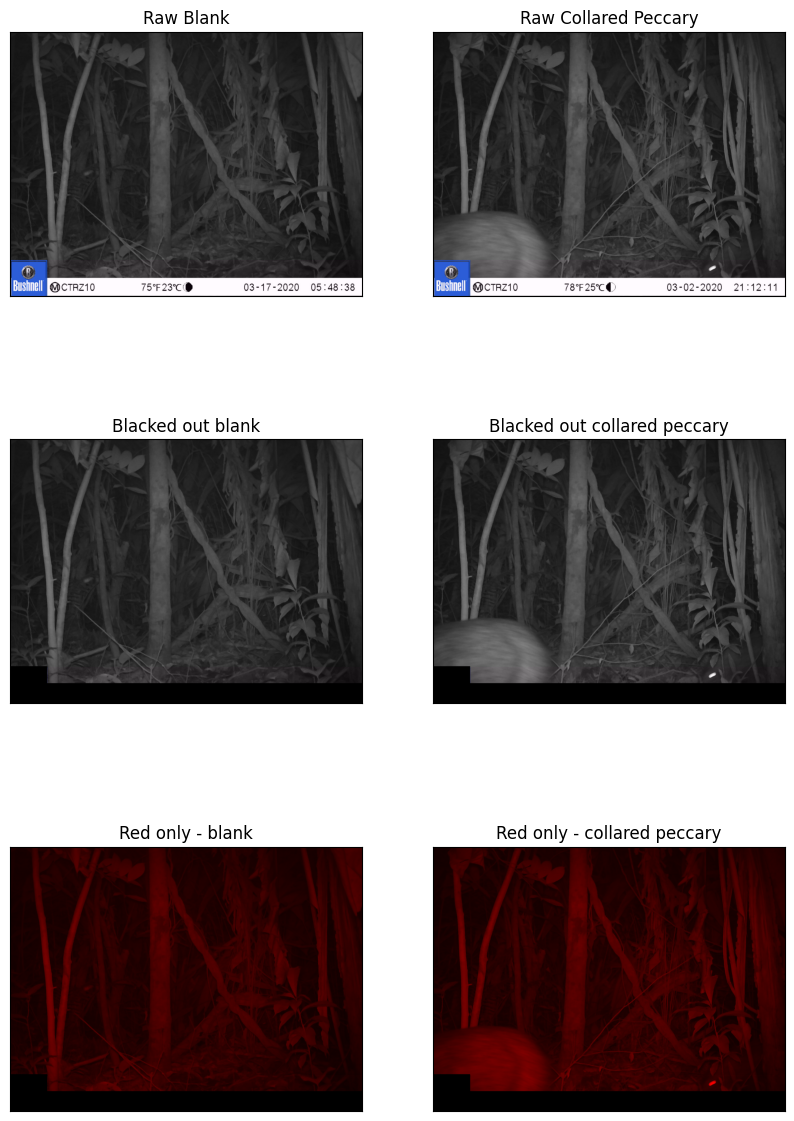

In [14]:
# show steps
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

#  Original images
axs[0, 0].imshow(blank_im, cmap='gray', vmin=0, vmax=1)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_title('Raw Blank')

axs[0, 1].imshow(cpec_im, cmap='gray', vmin=0, vmax=1)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].set_title('Raw Collared Peccary')


# Blacked out images
axs[1, 0].imshow(blank_bo, cmap='gray', vmin=0, vmax=1)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].set_title('Blacked out blank')

axs[1, 1].imshow(cpec_bo, cmap='gray', vmin=0, vmax=1)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].set_title('Blacked out collared peccary')

# Red channel only images
axs[2, 0].imshow(blank_im_red, cmap='gray', vmin=0, vmax=1)
axs[2, 0].set_xticks([])
axs[2, 0].set_yticks([])
axs[2, 0].set_title('Red only - blank')

axs[2, 1].imshow(cpec_im_red, cmap='gray', vmin=0, vmax=1)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
axs[2, 1].set_title('Red only - collared peccary')

plt.show()


# Background subtraction to create animal masks
Possible challenges:
- Since animals are found in different positions, a single mask couldn't be used to identify all animals in that class.
- Lightning conditions might be different, which is why histogram equalization was carried out.
- Background still changes (see example above, where there was a fallen branch).

In [15]:
print(np.max(blank_im_red))
print(np.max(cpec_im_red))

129
255


## Attempt 1: Create a binary mask using Otsu's thresholding

- [Otsu's thresholding](https://en.wikipedia.org/wiki/Otsu%27s_method): returns a single intensity threshold that separate pixels into two classes, foreground and background. This threshold is determined by minimizing intra-class intensity variance, or equivalently, by maximizing inter-class variance. Original paper: https://ieeexplore.ieee.org/document/4310076
- Mask also identifies trees in background

In [16]:
def create_mask(blank_path, cpec_path):
    # Load the images and convert to grayscale----------
    blank_im = cv2.imread(blank_path, cv2.IMREAD_GRAYSCALE)
    cpec_im = cv2.imread(cpec_path, cv2.IMREAD_GRAYSCALE)

    # Perform histogram equalization on the images
    blank_im_eq = cv2.equalizeHist(blank_im)
    cpec_im_eq = cv2.equalizeHist(cpec_im)

    # Blackout -----------------------------------------
    blank_bo = blank_im_eq.copy()
    cpec_bo = cpec_im_eq.copy()

    # Bottom row with metainfo
    blank_bo[1332:,] = 0
    cpec_bo[1332:,] = 0

    # Logo
    blank_bo[1240:1440,0:202] = 0
    cpec_bo[1240:1440,0:202] = 0

    # Background subtraction-------------------------------
    # Create a background subtractor object
    fgbg = cv2.createBackgroundSubtractorMOG2()

    # Initialize the background model with the blank image
    fgbg.apply(blank_bo)

    # Apply the background subtractor to the animal image
    fgmask = fgbg.apply(cpec_bo)

    # Create a binary mask using Otsu's thresholding
    _, mask = cv2.threshold(fgmask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Display the images and the mask using matplotlib
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(blank_im_eq, cmap='gray')
    axs[0].set_title('Blank Image')
    axs[1].imshow(cpec_im_eq, cmap='gray')
    axs[1].set_title('Peccary Image')
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Mask')
    plt.show()





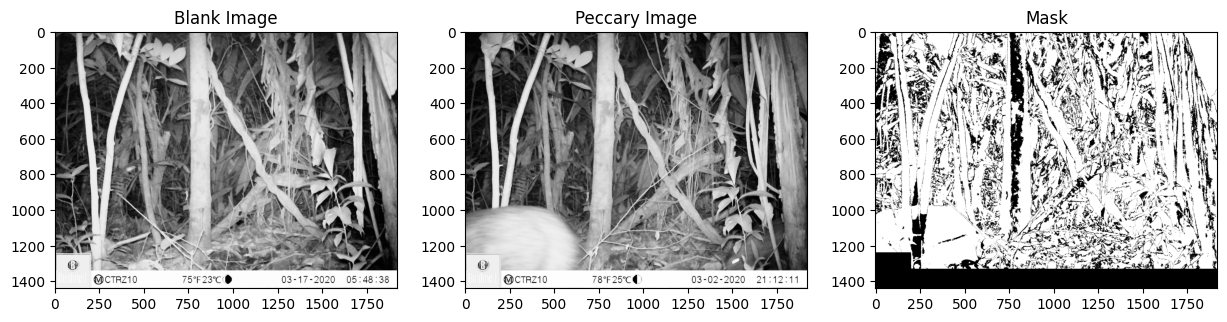

In [17]:
create_mask(blank, cpec)


## Attempt 2: Use a morphological opening operation to remove small regions of non-zero pixels in the mask

- Use a [morphological opening operation](https://https://www.mathworks.com/help/images/morphological-dilation-and-erosion.html) to remove small regions of non-zero pixels in the mask, eliminating some of the noise in the background.

1. Apply Otsu's thresholding to create a binary mask from the foreground mask fgmask.

2. Create a morphological structuring element using the cv2.getStructuringElement() [function](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html). This structuring element defines the shape and size of the neighborhood of pixels that will be used in the morphological operation. In this case, we use an elliptical structuring element with a size of 100x100 pixels (we experimented with sizes 5x5, 10x10, 100 x 100).

3. Apply a morphological opening operation to the mask using the cv2.morphologyEx() function with the cv2.MORPH_OPEN flag. This operation consists of an erosion followed by a dilation, and can help to remove small regions of non-zero pixels in the mask. The result is a mask that better separates the animal from the background.

In [18]:
def create_mask(blank_path, cpec_path):
    # Load the images
    blank_im = cv2.imread(blank_path, cv2.IMREAD_GRAYSCALE)
    cpec_im = cv2.imread(cpec_path, cv2.IMREAD_GRAYSCALE)

    # Perform histogram equalization on the images
    blank_im_eq = cv2.equalizeHist(blank_im)
    cpec_im_eq = cv2.equalizeHist(cpec_im)

    # Blackout -----------------------------------------
    blank_bo = blank_im_eq.copy()
    cpec_bo = cpec_im_eq.copy()

    # Bottom row with metainfo
    blank_bo[1332:,] = 0
    cpec_bo[1332:,] = 0

    # Logo
    blank_bo[1240:1440,0:202] = 0
    cpec_bo[1240:1440,0:202] = 0

    # Create a background subtractor object
    fgbg = cv2.createBackgroundSubtractorMOG2()

    # Initialize the background model with the blank image
    fgbg.apply(blank_bo)

    # Apply the background subtractor to the animal image
    fgmask = fgbg.apply(cpec_bo)

    # Create a binary mask using Otsu's thresholding
    _, mask = cv2.threshold(fgmask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply a morphological opening operation to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Display the images and the mask using matplotlib
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(blank_im_eq, cmap='gray')
    axs[0].set_title('Blank Image')
    axs[1].imshow(cpec_im_eq, cmap='gray')
    axs[1].set_title('Peccary Image')
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Mask')
    plt.show()


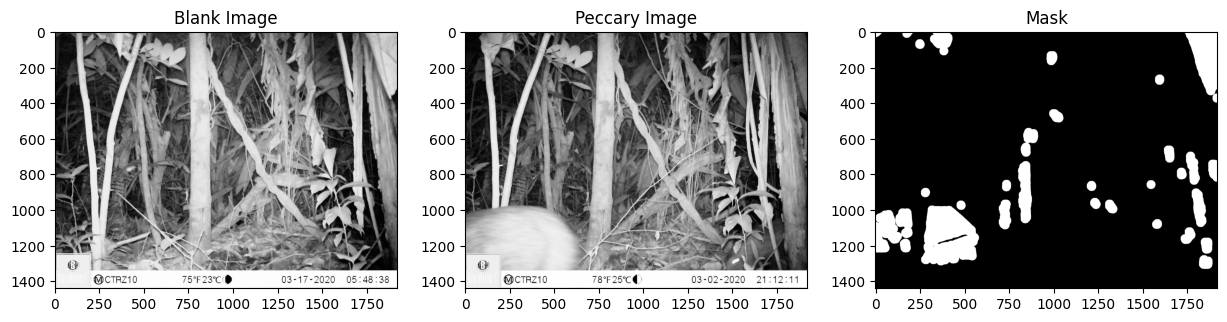

In [19]:
create_mask(blank, cpec)


## Attempt 3: Use multiple frames in order to have more consistency in the background.

Same as the function above, except it treats all blanks as one main background by combinging them!

In [56]:
# select images with multiple frames
def create_mask(blank_paths, cpec_path):
    # Create a background subtractor object
    fgbg = cv2.createBackgroundSubtractorMOG2()

    # Load and process each blank image
    for blank_path in blank_paths:
        # using above functions idea inside a loop
        blank_im = cv2.imread(blank_path, cv2.IMREAD_GRAYSCALE)
        blank_im_eq = cv2.equalizeHist(blank_im)
        blank_bo = blank_im_eq.copy()
        blank_bo[1332:,] = 0
        blank_bo[1240:1440,0:202] = 0
        fgbg.apply(blank_bo)

    # Load the foreground image
    cpec_im = cv2.imread(cpec_path, cv2.IMREAD_GRAYSCALE)
    cpec_im_eq = cv2.equalizeHist(cpec_im)
    cpec_bo = cpec_im_eq.copy()
    cpec_bo[1332:,] = 0
    cpec_bo[1240:1440,0:202] = 0

    # Apply the background subtractor to the animal image
    fgmask = fgbg.apply(cpec_bo)

    # Create a binary mask using Otsu's thresholding
    _, mask = cv2.threshold(fgmask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply a morphological opening operation to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Display the images and the mask using matplotlib
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(blank_im_eq, cmap='gray')
    axs[0].set_title('Blank Image')
    axs[1].imshow(cpec_im_eq, cmap='gray')
    axs[1].set_title('Peccary Image')
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Mask')
    plt.show()

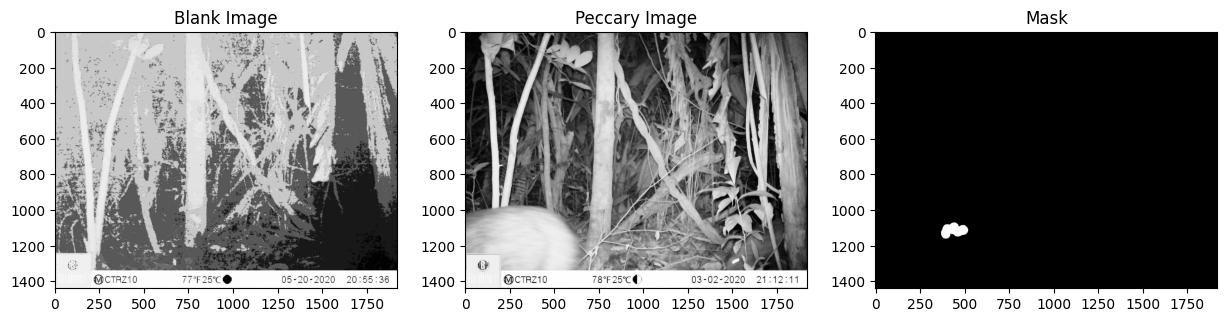

In [57]:
create_mask(blanks, cpec)

Now we need to be able to run this on an arbitrary camera, lets load in functionality to get X number of blanks and load them for a desired camera.

In [60]:
def get_camera_blanks(df, path, camera, amount):
  """
  Function to get {amount} of blanks from a desired {camera}.
  @params:
    - df     -> the pandas df to work with on camera and file info
    - path   -> base path to appear before file names
    - camera -> the desired camera to get the blanks from
    - amount -> how many blanks to gather from the desired camera
  """
  try:
    # get the names of the files that are blank
    blank_files = []
    # grab all values that are Blank under this camera but only the desired amount
    extracted_df = df[(df['common_name'] == "Blank") & (df['camera'] == camera)].sort_values('camera').iloc[:amount]
    # grab the file names and update the list
    for index, row in extracted_df.iterrows():
      blank_files.append(f"{path}/{row['filename']}")
    return blank_files
  except Exception as e:
    print(f"Cannot extract info from data source...\n{e}")

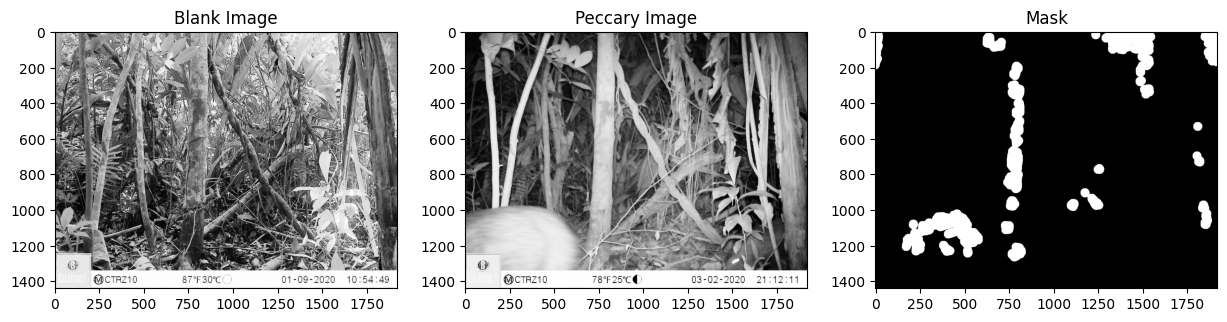

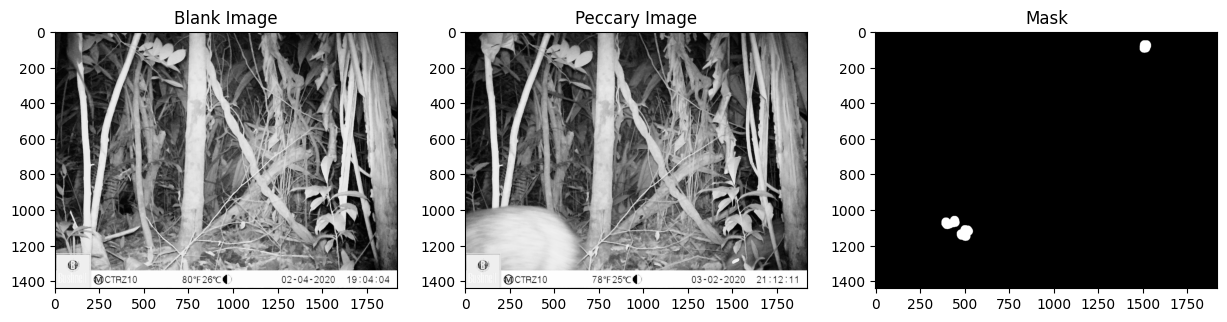

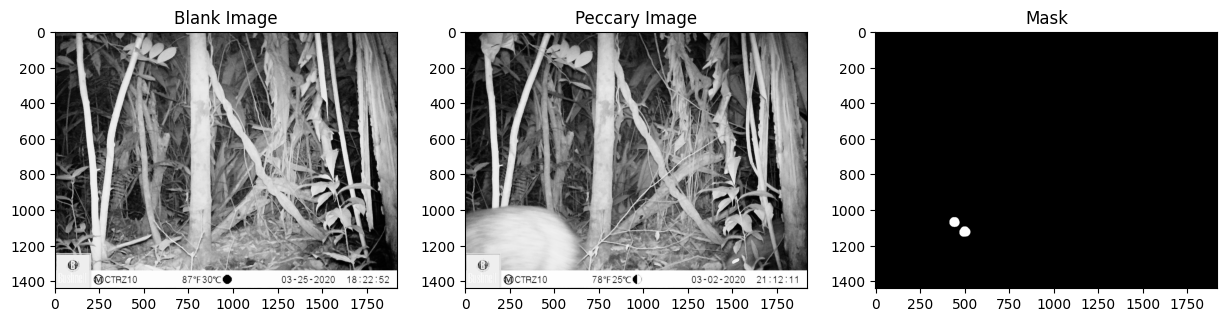

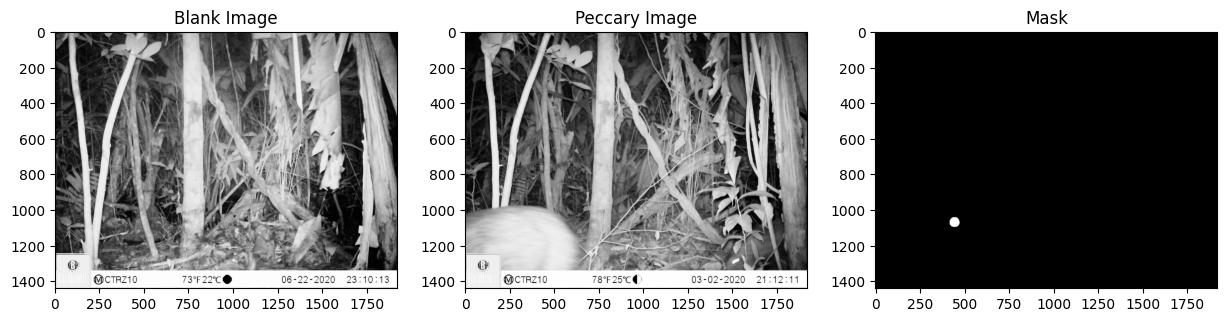

In [61]:
# test differences with different blank amounts (the blank image will be the last loaded one)
for amount in [2,4,6,8]:
  new_blanks = get_camera_blanks(image_labels, base_path, "A01", amount)
  # now call the masking function with the new blanks
  create_mask(new_blanks, cpec)